# DSCI 552 Assigment 5 Part 1

For [rod pumps](https://www.youtube.com/watch?v=nhxbfMG1y1s), a dynamometer card plots the stroke position (i.e., vertical displacement) of the pump versus the load on the pump.

The shape of dynamometer cards can be used to diagnosis problems, see:
* [Dyno Survey](https://www.downholediagnostic.com/dynamometer)
* [Dynamometer card common shapes and description](https://www.researchgate.net/figure/Dynamometer-card-common-shapes-and-description-Wang-et-al-2021_tbl1_354171410)


## Imports

In [1]:
# Add more imports as needed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.cluster import MiniBatchKMeans, KMeans, AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

## Load Data

In [2]:
# Loading the Data
datafile = 'DSCI_552_CardShape_2014_01_01.csv.gz'
data_raw = pd.read_csv(datafile)

In [3]:
data_raw

,WellName,CardDate,CardType,CardLocation,NumPoints,Position0,Position1,Position2,Position3,Position4,...,Load190,Load191,Load192,Load193,Load194,Load195,Load196,Load197,Load198,Load199
0,QFB 0,2014-01-01 03:41:30,POF,SU,200,85.50,85.50,86.00,86.25,86.50,...,4397.0,4343.0,4281.0,4207.0,4152.0,4121.0,4118.0,4077.0,4033.0,3933.0
1,QFB 1,2014-01-01 02:58:06,CUR,SU,200,48.00,48.00,48.00,47.75,47.75,...,3546.0,3602.0,3654.0,3687.0,3703.0,3690.0,3684.0,3683.0,3672.0,3588.0
2,QFB 2,2014-01-01 03:46:30,POF,SU,200,84.00,84.00,83.75,83.75,83.75,...,3039.0,3034.0,3031.0,3011.0,3000.0,2996.0,2997.0,3000.0,3002.0,2979.0
3,QFB 5,2014-01-01 02:38:54,CUR,SU,200,40.25,40.25,40.25,40.25,40.00,...,3023.0,3003.0,2983.0,2956.0,2926.0,2902.0,2884.0,2862.0,2827.0,2685.0
4,QFB 6,2014-01-01 02:50:36,CUR,SU,200,100.00,100.00,99.75,99.75,99.50,...,3678.0,3624.0,3636.0,3571.0,3590.0,3557.0,3528.0,3527.0,3519.0,3322.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8176,GTV 19H,2014-01-01 06:39:30,CUR,SU,200,0.50,0.50,0.75,1.00,1.25,...,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0
8177,GTV 20,2014-01-01 04:09:18,CUR,SU,200,48.00,48.00,48.00,47.75,47.75,...,2686.0,2684.0,2676.0,2664.0,2652.0,2641.0,2631.0,2623.0,2626.0,2626.0
8178,GTV 21,2014-01-01 03:26:30,CUR,SU,200,35.25,35.25,35.25,35.50,35.50,...,2501.0,2488.0,2477.0,2474.0,2470.0,2469.0,2466.0,2460.0,2455.0,2433.0
8179,GTV 22,2014-01-01 03:05:12,CUR,SU,200,36.00,36.00,36.00,35.75,35.75,...,2198.0,2202.0,2186.0,2177.0,2174.0,2151.0,2130.0,2121.0,2104.0,2110.0


## Initial data exploration

### TODO: Number of unique wells by WellName

In [4]:
# Number of unique wells by WellName
unique_wells_count = data_raw['WellName'].nunique()
print(f"Number of unique wells: {unique_wells_count}")

# There are 8,073 unique wells in the dataset.

Number of unique wells: 8073


### TODO: Statistics on number of cards per well
Create DataFrame (or Series) to show number of wells that have only one card, only two cards, only three cards and so on.

In [5]:
# Statistics on number of cards per well
cards_per_well = data_raw.groupby('WellName').size()
cards_distribution = cards_per_well.value_counts().sort_index()

wells_count_by_cards_df = cards_distribution.reset_index()
wells_count_by_cards_df.columns = ['NumberofCards', 'NumberofWells']
print(wells_count_by_cards_df)

# The dataset contains 7,973 wells with only one card, 92 wells with two cards, and 8 wells with three cards.

   NumberofCards  NumberofWells
0              1           7973
1              2             92
2              3              8


### Focus on cards with exactly 200 points 

In [6]:
d200 = data_raw[data_raw['NumPoints']==200]
d200

# The filtered data (d200) includes only the cards that have exactly 200 points.

,WellName,CardDate,CardType,CardLocation,NumPoints,Position0,Position1,Position2,Position3,Position4,...,Load190,Load191,Load192,Load193,Load194,Load195,Load196,Load197,Load198,Load199
0,QFB 0,2014-01-01 03:41:30,POF,SU,200,85.50,85.50,86.00,86.25,86.50,...,4397.0,4343.0,4281.0,4207.0,4152.0,4121.0,4118.0,4077.0,4033.0,3933.0
1,QFB 1,2014-01-01 02:58:06,CUR,SU,200,48.00,48.00,48.00,47.75,47.75,...,3546.0,3602.0,3654.0,3687.0,3703.0,3690.0,3684.0,3683.0,3672.0,3588.0
2,QFB 2,2014-01-01 03:46:30,POF,SU,200,84.00,84.00,83.75,83.75,83.75,...,3039.0,3034.0,3031.0,3011.0,3000.0,2996.0,2997.0,3000.0,3002.0,2979.0
3,QFB 5,2014-01-01 02:38:54,CUR,SU,200,40.25,40.25,40.25,40.25,40.00,...,3023.0,3003.0,2983.0,2956.0,2926.0,2902.0,2884.0,2862.0,2827.0,2685.0
4,QFB 6,2014-01-01 02:50:36,CUR,SU,200,100.00,100.00,99.75,99.75,99.50,...,3678.0,3624.0,3636.0,3571.0,3590.0,3557.0,3528.0,3527.0,3519.0,3322.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8176,GTV 19H,2014-01-01 06:39:30,CUR,SU,200,0.50,0.50,0.75,1.00,1.25,...,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0,-127.0
8177,GTV 20,2014-01-01 04:09:18,CUR,SU,200,48.00,48.00,48.00,47.75,47.75,...,2686.0,2684.0,2676.0,2664.0,2652.0,2641.0,2631.0,2623.0,2626.0,2626.0
8178,GTV 21,2014-01-01 03:26:30,CUR,SU,200,35.25,35.25,35.25,35.50,35.50,...,2501.0,2488.0,2477.0,2474.0,2470.0,2469.0,2466.0,2460.0,2455.0,2433.0
8179,GTV 22,2014-01-01 03:05:12,CUR,SU,200,36.00,36.00,36.00,35.75,35.75,...,2198.0,2202.0,2186.0,2177.0,2174.0,2151.0,2130.0,2121.0,2104.0,2110.0


### TODO: Plot 10 card shapes
Generate one line plot of the first 10 cards. 
* The x values should be positions d200.iloc[i, 5:205]
* The y values should be loads d200.iloc[i, 205:405]

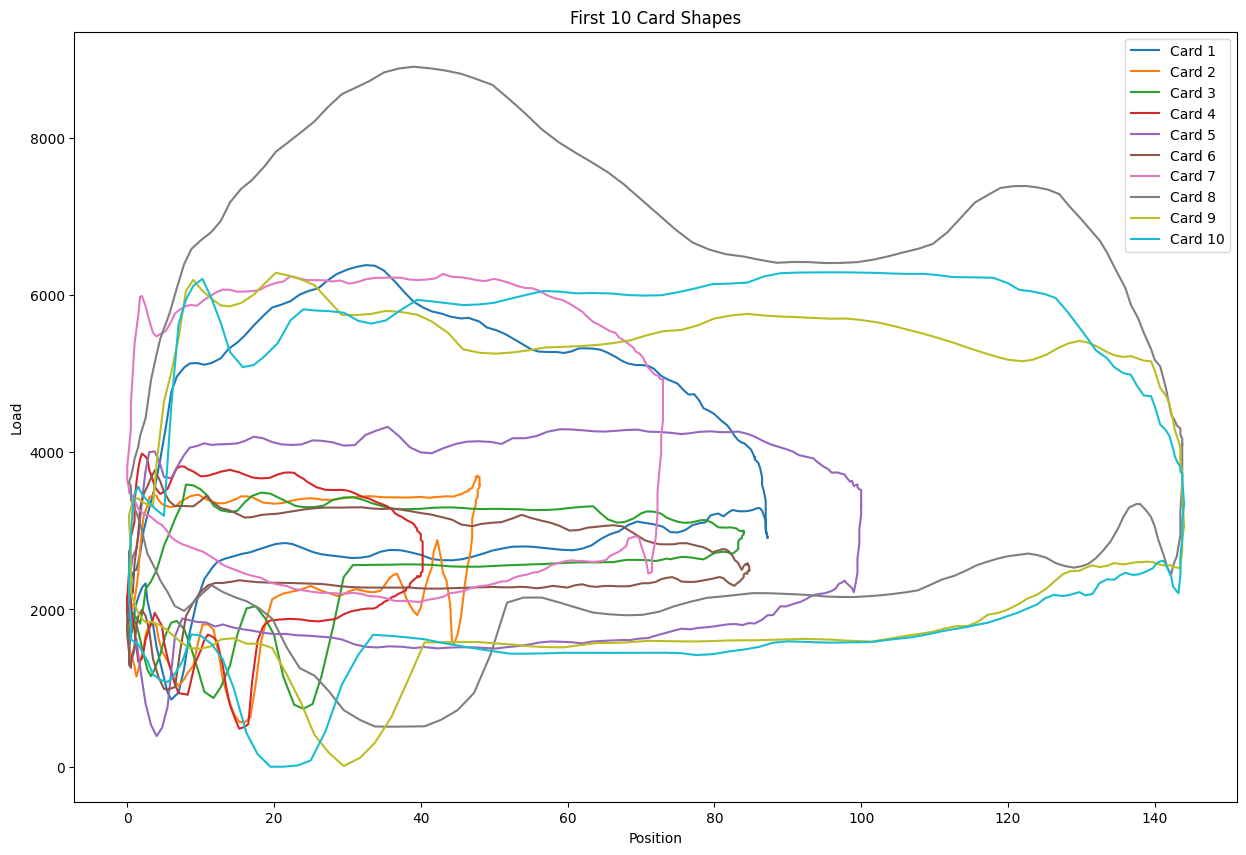

In [7]:
# Plot 10 card shapes
plt.figure(figsize=(15, 10))
for i in range(10):
    positions = d200.iloc[i, 5:205]
    loads = d200.iloc[i, 205:405]
    plt.plot(positions, loads, label=f'Card {i+1}')
plt.title('First 10 Card Shapes')
plt.xlabel('Position')
plt.ylabel('Load')
plt.legend()
plt.show()

### TODO: Plot the load profiles
Generate one line plot of the profiles of first 10 cards, i.e., the x-axis is just range(200) and y-axis is load. 

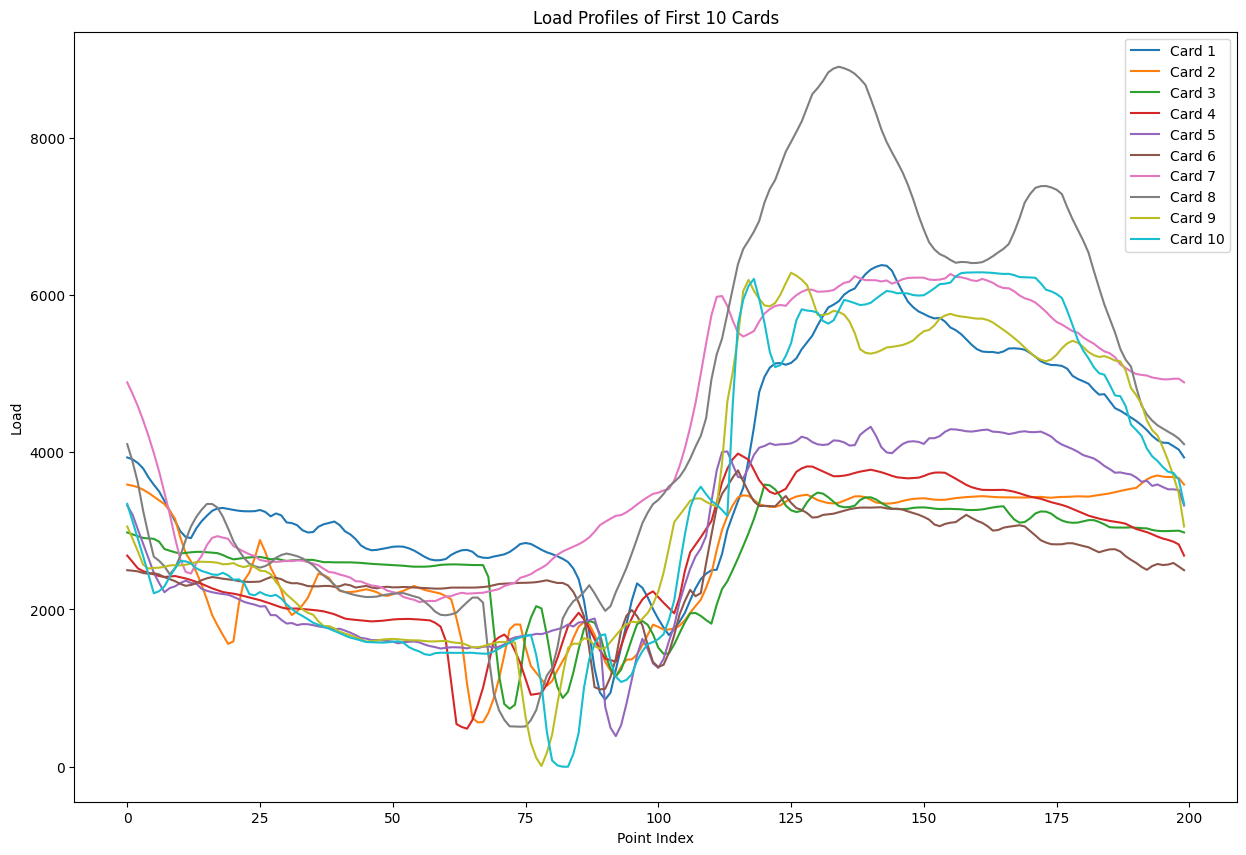

In [8]:
# Plot the load profiles of the first 10 cards
plt.figure(figsize=(15, 10))
for i in range(10):
    loads = d200.iloc[i, 205:405]
    plt.plot(range(200), loads, label=f'Card {i+1}')
plt.title('Load Profiles of First 10 Cards')
plt.xlabel('Point Index')
plt.ylabel('Load')
plt.legend()
plt.show()

### TODO: Plot the position profiles
Generate one line plot of the position of first 10 cards, i.e., the x-axis is range(200) and y-axis is position. 

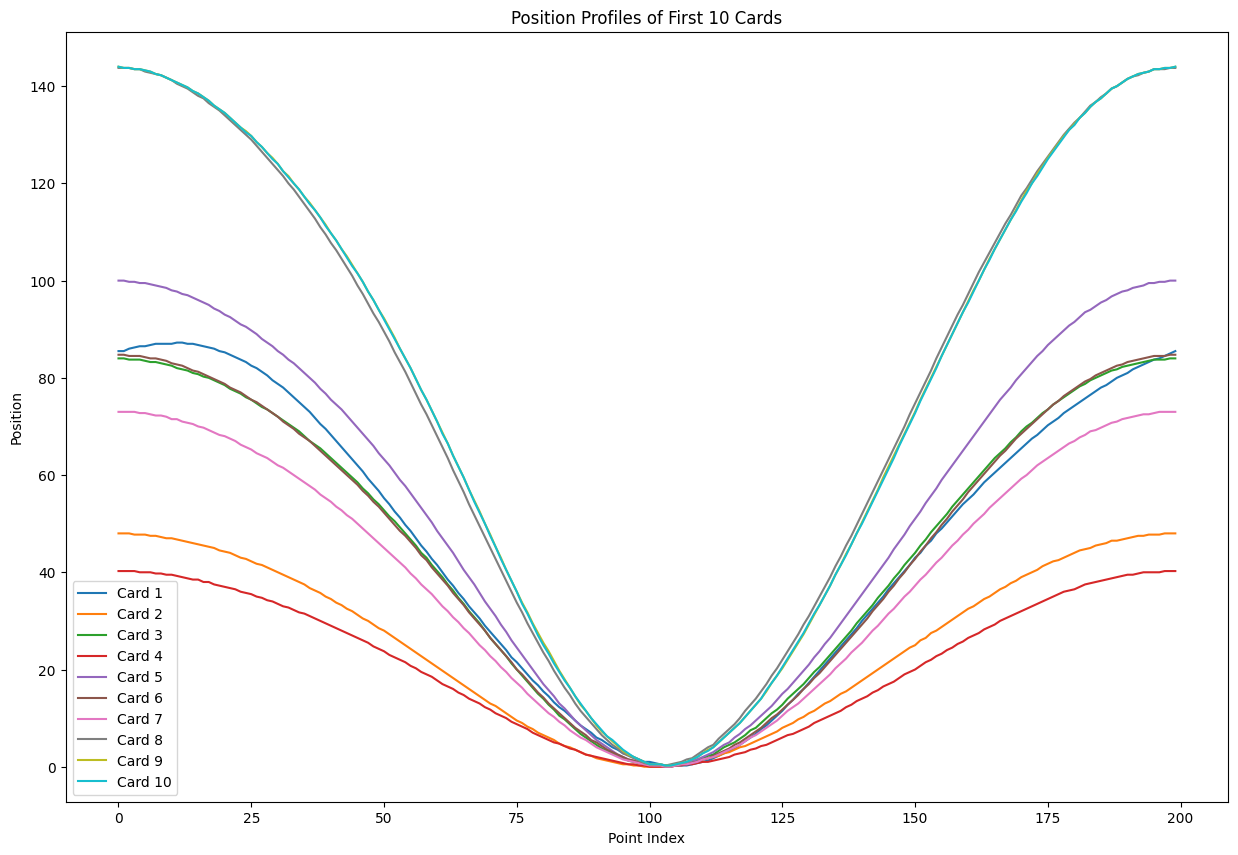

In [9]:
# Plot the position profiles of the first 10 cards
plt.figure(figsize=(15, 10))
for i in range(10):
    positions = d200.iloc[i, 5:205]
    plt.plot(range(200), positions, label=f'Card {i+1}')
plt.title('Position Profiles of First 10 Cards')
plt.xlabel('Point Index')
plt.ylabel('Position')
plt.legend()
plt.show()

### TODO: Position Profiles
What do the the position profiles look 

Based on the graph for the position profiles of the first 10 cards, the below observations can be made:

Profile Shape: The shapes are characteristic of what you might expect from a rod pump's vertical displacement: starting at a high position, curving down to a low point, and then curving back up. This is typical of the upstroke and downstroke of a pumping cycle.

Consistency: There seems to be a consistent pattern in the profile shapes, indicating that these ten wells may be operating under similar conditions. The uniformity suggests that the pumps are performing a complete and full stroke.

Variability: Although the overall patterns are consistent, there is some variability among the cards. Some cards reach a lower minimum position than others. This could be due to differences in the stroke lengths or due to different subsurface conditions.

Smoothness: The curves are mostly smooth without abrupt changes in slope, which would suggest that there aren’t any sudden blockages or restrictions in the well during these strokes.

Symmetry: The curves appear relatively symmetric around the lowest point of the stroke, which could imply that the pump units are well-balanced, and there are no significant issues with the upstroke versus the downstroke.

Maximum and Minimum Values: The maximum and minimum values of the positions vary among the cards, which might be indicative of different settings or configurations for each pump (like different rod lengths, pump depths, or mechanical settings).

### TODO: Max position profiles
Plot position curves using max values over all cards

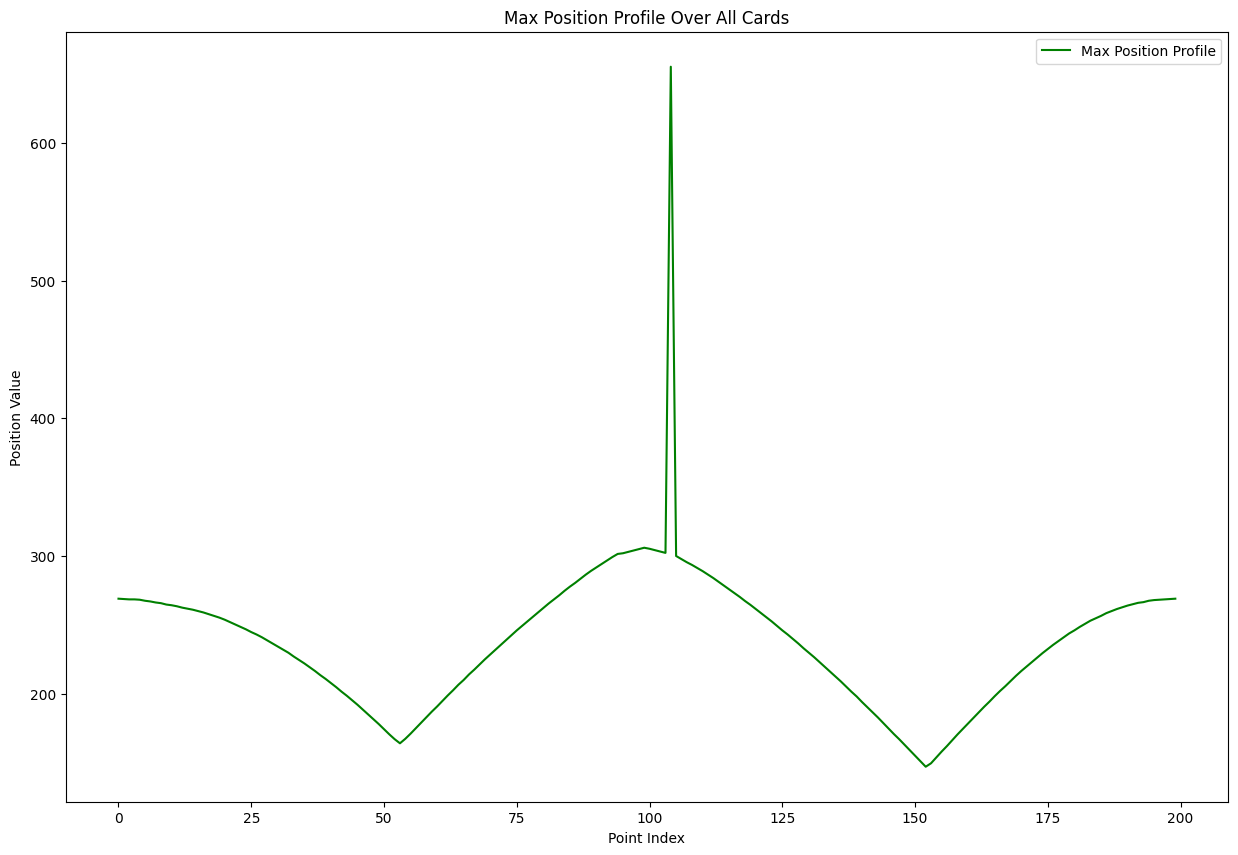

In [10]:
# Plot position curves using max values over all cards
max_positions = d200.loc[:, 'Position0':'Position199'].max()
plt.figure(figsize=(15, 10))
plt.plot(range(200), max_positions, label='Max Position Profile', color='green')
plt.title('Max Position Profile Over All Cards')
plt.xlabel('Point Index')
plt.ylabel('Position Value')
plt.legend()
plt.show()

### TODO: Comment on the max position profiles
Based on the first position plot of the first 10 cards, what max profile were you expecting?

The graph for the max position profile shows an interesting feature: a very sharp peak at around the midpoint of the point index range. Here's what can be interpreted:

Sharp Peak: The extreme spike in the middle is quite unusual for a normal rod pump operation profile. This could be due to an outlier or an anomalous event in the dataset where, for some reason, a pump had an exceptionally high stroke position at that point.

Data Outlier: Considering the rest of the profile appears smooth and typical of a rod pump cycle, the peak might be a data anomaly. This could result from a measurement error, data corruption, or an extraordinary event that is not characteristic of normal pump behavior.

Contrast with Expectations: Based on the smoothness of the first 10 position profiles, one would expect the max profile to be a smooth curve as well, without any sharp spikes. The peak does not fit the expected envelope of maximum values that would normally be formed by the uppermost points of the first 10 profiles.

Impact on Analysis: Such a peak can significantly affect the scaling of the graph and might obscure the true nature of the rest of the data. It could be beneficial to examine the data excluding this outlier to better understand the typical max position profile behavior.

Operational Insight: If the peak is not an error, it could be indicative of a rare but severe condition in one of the wells, such as a stick-slip motion of the pump or a momentary blockage that caused an abnormal increase in the stroke length.

### TODO: Plot min position profile

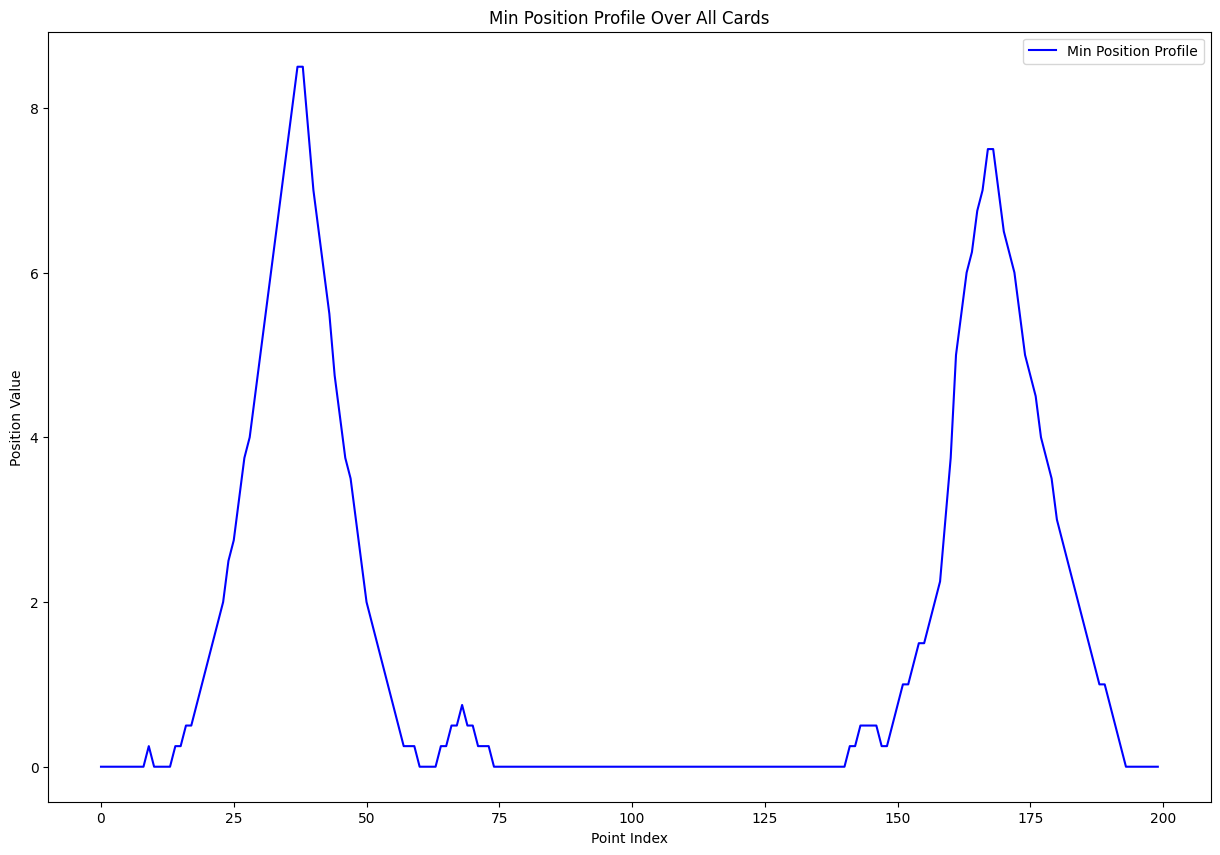

In [11]:
# Plot min position profile
min_positions = d200.loc[:, 'Position0':'Position199'].min()
plt.figure(figsize=(15, 10))
plt.plot(range(200), min_positions, label='Min Position Profile', color='blue')
plt.title('Min Position Profile Over All Cards')
plt.xlabel('Point Index')
plt.ylabel('Position Value')
plt.legend()
plt.show()

### TODO: Comment on the min position profiles
Based on the first position plot of the first 10 cards, what min profile were you expecting?
How would you explain this min profile? Generate more plots to explain this min profile.

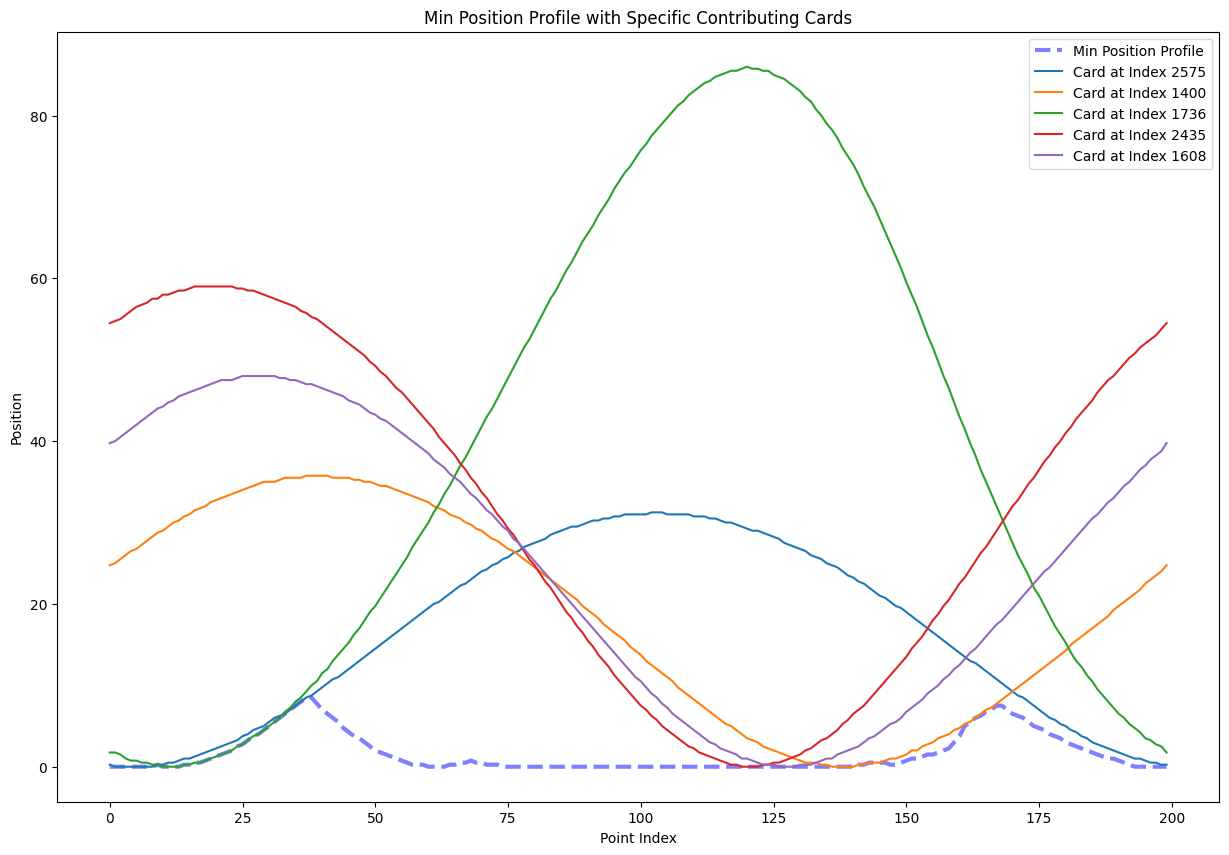

In [12]:
# Identifying the cards contributing to the minimum position at specific points
min_positions_index = d200.loc[:, 'Position0':'Position199'].idxmin()

# Plotting a selection of these specific card profiles along with the overall min profile for comparison
plt.figure(figsize=(15, 10))

# Plotting the overall min position profile for context
plt.plot(range(200), min_positions, label='Min Position Profile', color='blue', linewidth=3, linestyle='--', alpha=0.5)

# Selecting a few specific indexes for detailed plotting
selected_indexes = min_positions_index.drop_duplicates().sample(n=5, random_state=1)

for index in selected_indexes:
    positions = d200.loc[index, 'Position0':'Position199']
    plt.plot(range(200), positions, label=f'Card at Index {index}')

plt.title('Min Position Profile with Specific Contributing Cards')
plt.xlabel('Point Index')
plt.ylabel('Position')
plt.legend()
plt.show()

The minimum position profile depicted in the graph is quite distinctive and does not follow the continuous, smooth curve that one might expect from a typical minimum envelope of the position profiles for a set of rod pump dynamometer cards. Here's how we can interpretation:

Sharp Peaks: The graph shows two very sharp peaks which are unusual. Normally, we would expect the minimum profile to follow the bottom contours of the card shapes shown in the first position plot of the first 10 cards. Such sharp peaks could indicate that at two specific points in the stroke cycle, all cards recorded a relatively high position value that was not typical of the rest of the cycle.

Expectation vs. Reality: Based on the previous plot of the first 10 cards, the minimum profile would be expected to be a smooth curve near the lower bounds of those plots. The sharp peaks suggest that there may be outliers or unusual events that are affecting the minimum values at those specific point indices.

Possible Data Issues: This profile may also raise questions about the data quality. It's possible that there may be errors or anomalies in the dataset that resulted in such sharp peaks for the minimum values. It would be important to investigate these particular points further to ensure they are accurate and not a result of data corruption or mis-recording.

Operational Implications: If the data is accurate, these peaks might indicate a condition in the well that consistently causes the pump to have a higher position than expected at those points in the stroke cycle. This could be indicative of a mechanical issue or a downhole condition that affects the pump at those specific times.

# Remove outlier

## TODO: find outlier card

Which card caused the peak around position 105? 

In [13]:
# Extracting the position data for point index 105
position_105 = d200.iloc[:, 105]

# Finding the card with the maximum position value at index 105
max_position_105_index = position_105.idxmax()
outlier_card = d200.loc[max_position_105_index]

print(max_position_105_index)
#print(outlier_card)

1883


### TODO: plot this oulier card

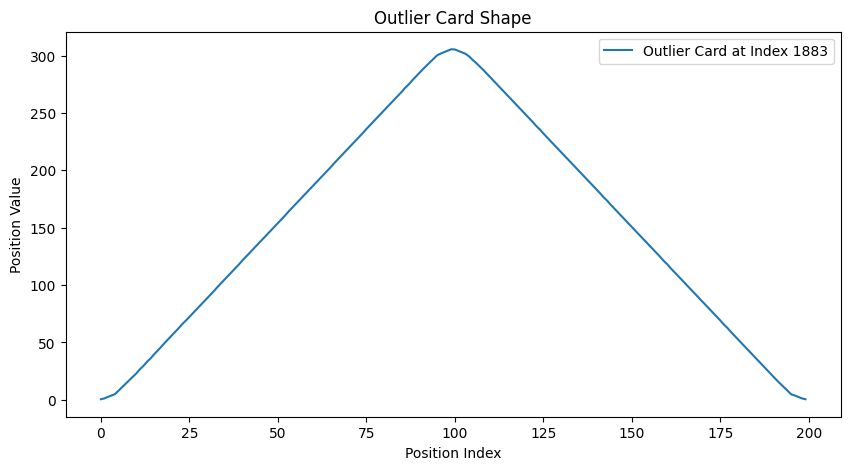

In [14]:
# Plotting this outlier card
plt.figure(figsize=(10, 5))
plt.plot(range(200), outlier_card[5:205], label=f'Outlier Card at Index {max_position_105_index}')
plt.title('Outlier Card Shape')
plt.xlabel('Position Index')
plt.ylabel('Position Value')
plt.legend()
plt.show()

### TODO: Create a new dataset by removing this outlier

In [15]:
# Creating a new dataset by removing this outlier
d200_clean = d200.drop(max_position_105_index)

# Checking the removal of the outlier
outlier_removed_check = max_position_105_index not in d200_clean.index
outlier_removed_check, d200_clean.shape

(True, (6445, 405))

# Dimensionality Reduction

Let's continue analyzing the positions using PCA

### TODO: Project the positions down to 10 dimensions using PCA

Store the resulting project as a DataFrame in `pos_pca`

In [16]:
# Creating PCA with 10 components
pca_clean = PCA(n_components=10)
pos_pca_data = pca_clean.fit_transform(d200_clean.iloc[:, 5:205])
pos_pca = pd.DataFrame(pos_pca_data, index=d200_clean.index)
#print(pos_pca_data)
print(pos_pca)

               0           1          2         3         4          5  \
0      70.632598  -22.959193  21.771822  0.914564 -0.479635  26.094018   
1    -282.164850  -43.370602  -8.241142  0.062305 -0.126682  -0.031340   
2      53.756274  -22.670253  -5.565740 -7.117230  0.601291  -0.072856   
3    -352.753004  -46.358138   2.057500  0.467996 -0.308260  -2.596146   
4     195.862062  -16.128152  -0.525621 -5.271473  0.340379   0.131122   
...          ...         ...        ...       ...       ...        ...   
8176 -424.143170  667.045447  36.635289 -4.930652 -0.256620  10.517476   
8177 -284.804232  -45.519357  -6.941551  2.055120 -0.200985  -1.855265   
8178 -391.006041  -43.786846  24.260991 -2.171783 -0.014170   1.184765   
8179 -401.060490  -52.928534  18.571057  8.024418 -0.816701  -7.586703   
8180 -286.267791  -30.789544  72.466607  4.457481 -0.405007   5.727418   

             6         7         8         9  
0    -7.938692 -5.980582  2.390677  0.862998  
1     0.587385  0

### TODO: Using a single figure to plot the first five principal components

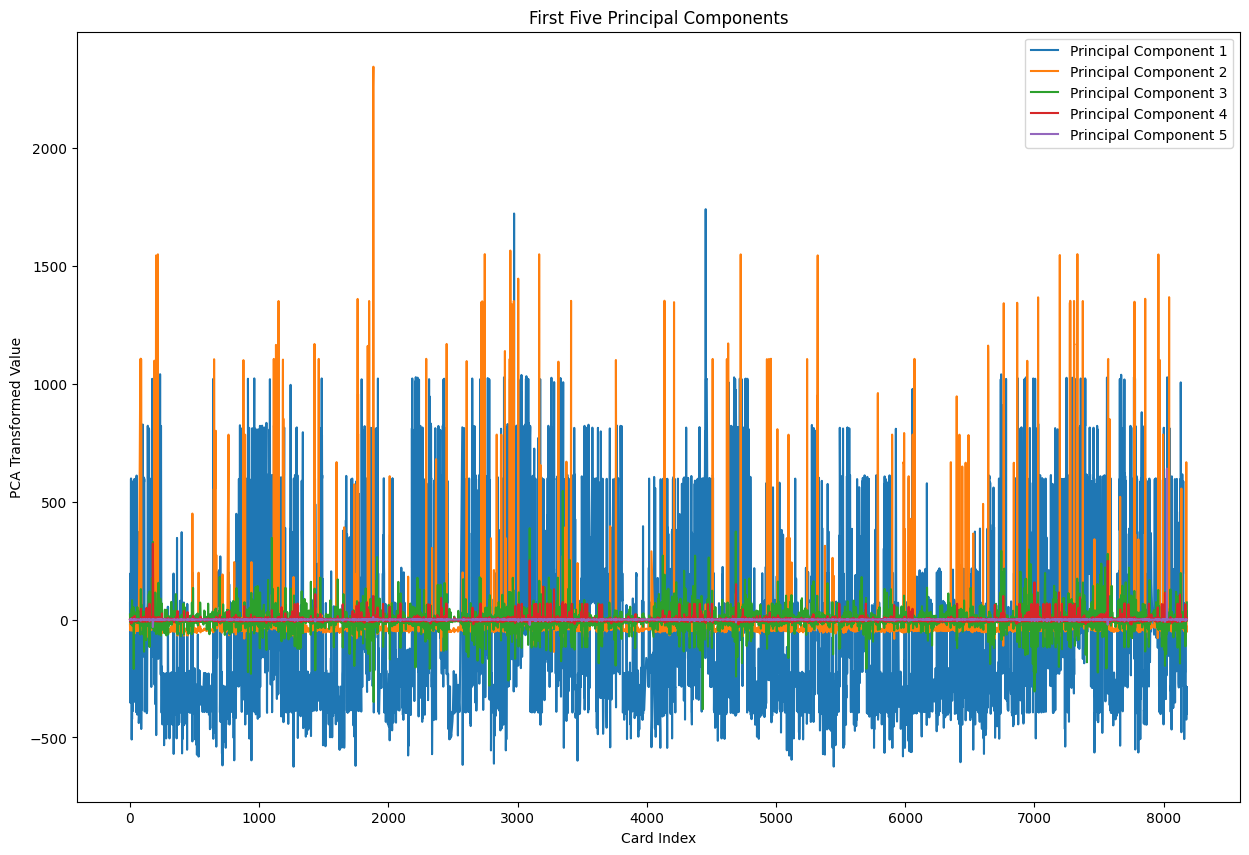

In [17]:
# Plotting the first five principal components
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.plot(pos_pca[i], label=f'Principal Component {i+1}')
plt.title('First Five Principal Components')
plt.xlabel('Card Index')
plt.ylabel('PCA Transformed Value')
plt.legend()
plt.show()

### TODO: Create scatter plot using first two coordinates of the PCA transformed coordinates

You should see to distinct clusters.

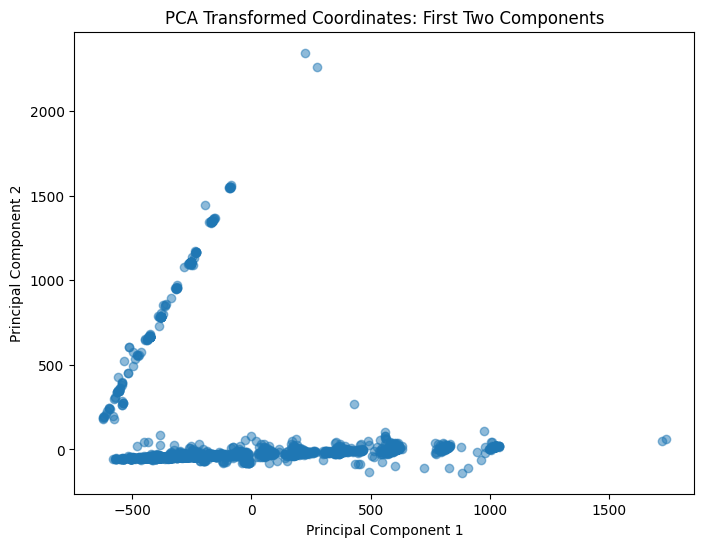

In [18]:
# Creating scatter plot using first two coordinates of the PCA transformed coordinates
plt.figure(figsize=(8, 6))
plt.scatter(pos_pca[0], pos_pca[1], alpha=0.5)
plt.title('PCA Transformed Coordinates: First Two Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### TODO: Generate position profiles plots for each of the two clusters

Draw profiles by sampling from each of the clusters.

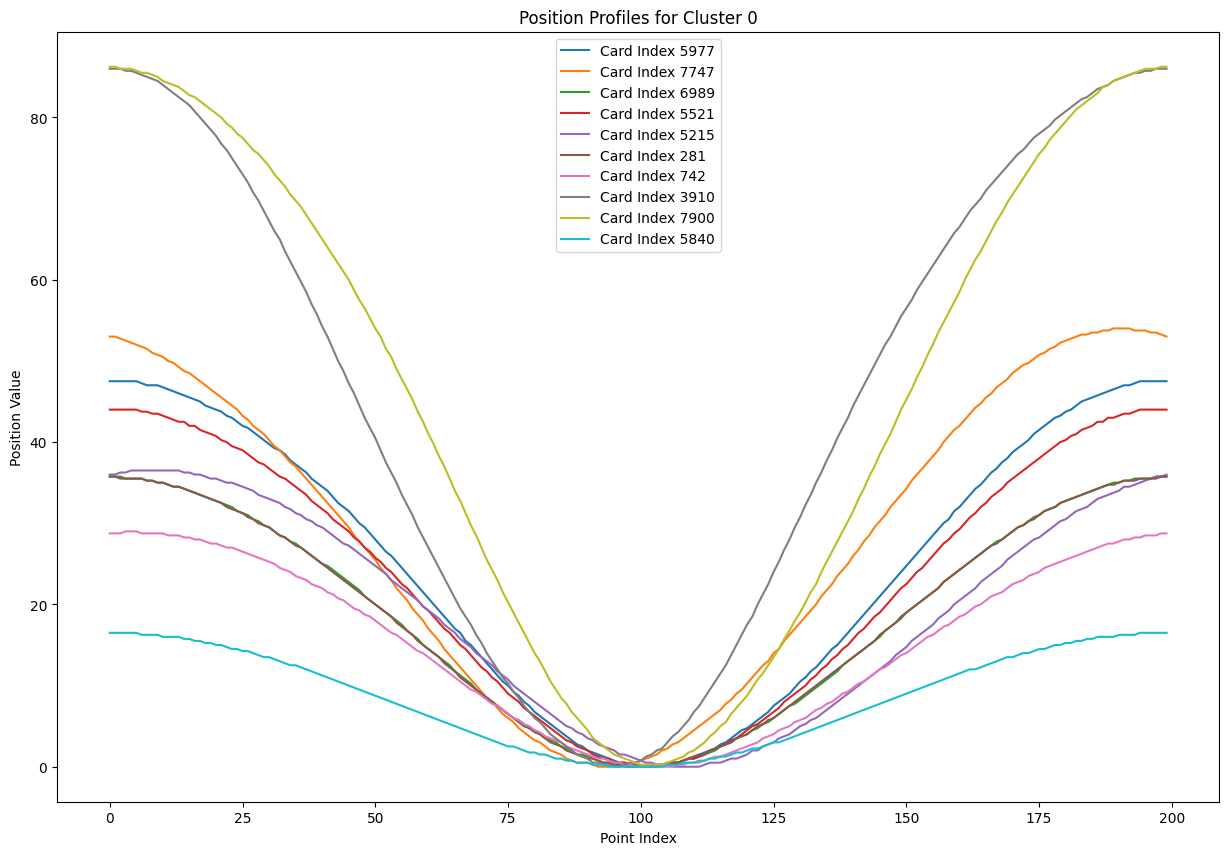

In [19]:
# Perform KMeans clustering to divide the data into two clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(pos_pca)

# Assign the cluster labels back to your dataframe
d200_clean['cluster'] = kmeans.labels_

# Define a function to plot position profiles for a given cluster
def plot_position_profiles_for_cluster(cluster_data, cluster_label):
    plt.figure(figsize=(15, 10))
    for i, row in cluster_data.iterrows():
        positions = row['Position0':'Position199']
        plt.plot(range(200), positions, label=f'Card Index {i}')
    plt.title(f'Position Profiles for Cluster {cluster_label}')
    plt.xlabel('Point Index')
    plt.ylabel('Position Value')
    plt.legend()
    plt.show()

# Sample a few cards from each cluster
sample_size = 10 # or any number you prefer
cluster_0_sample = d200_clean[d200_clean['cluster'] == 0].sample(n=sample_size, random_state=0)
# cluster_1_sample = d200_clean[d200_clean['cluster'] == 1].sample(n=sample_size, random_state=0)

# Plot position profiles for each cluster
plot_position_profiles_for_cluster(cluster_0_sample, 0)
# plot_position_profiles_for_cluster(cluster_1_sample, 1)

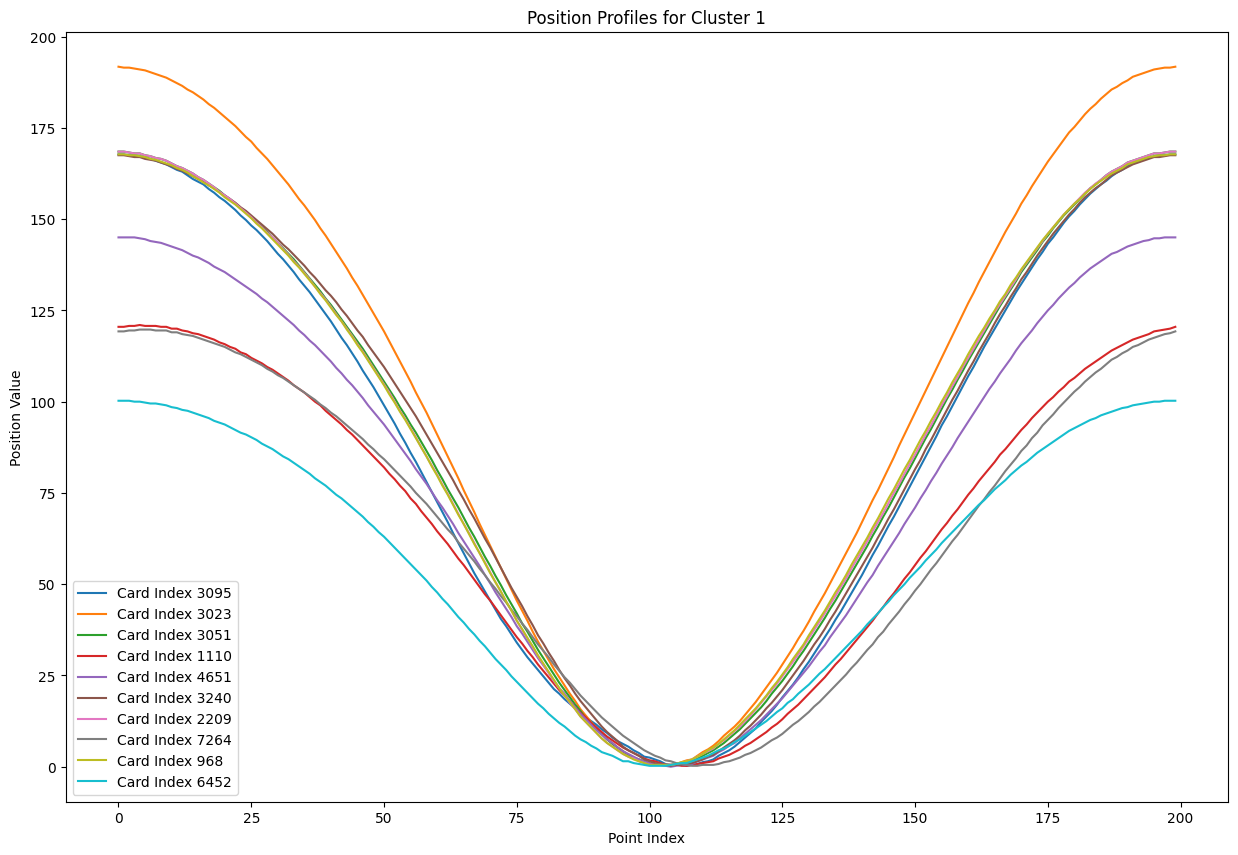

In [20]:
# Perform KMeans clustering to divide the data into two clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(pos_pca)

# Assign the cluster labels back to your dataframe
d200_clean['cluster'] = kmeans.labels_

# Define a function to plot position profiles for a given cluster
def plot_position_profiles_for_cluster(cluster_data, cluster_label):
    plt.figure(figsize=(15, 10))
    for i, row in cluster_data.iterrows():
        positions = row['Position0':'Position199']
        plt.plot(range(200), positions, label=f'Card Index {i}')
    plt.title(f'Position Profiles for Cluster {cluster_label}')
    plt.xlabel('Point Index')
    plt.ylabel('Position Value')
    plt.legend()
    plt.show()

# Sample a few cards from each cluster
sample_size = 10 # or any number you prefer
# cluster_0_sample = d200_clean[d200_clean['cluster'] == 0].sample(n=sample_size, random_state=0)
cluster_1_sample = d200_clean[d200_clean['cluster'] == 1].sample(n=sample_size, random_state=0)

# Plot position profiles for each cluster
# plot_position_profiles_for_cluster(cluster_0_sample, 0)
plot_position_profiles_for_cluster(cluster_1_sample, 1)

### TODO: What do the clusters represent?

By examining the position profiles within each cluster, we can deduce the following:

Cluster 0:
The position profiles in Cluster 0 have lower amplitude, meaning the vertical displacement for these pumps is less compared to Cluster 1. This indicate a shorter stroke length or less vertical movement required for the pumping action.

The profiles are quite similar to each other, suggesting consistent pumping action among the wells in this cluster.

The closeness of the curves suggests that the wells in this cluster are likely experiencing similar subsurface conditions or are set up with similar equipment configurations.


Cluster 1:
The position profiles for Cluster 1 show a greater vertical displacement as indicated by the higher amplitude of the curves. This suggest a longer stroke length or that these pumps are designed to cover more vertical distance in their operation.

Similar to Cluster 0, the profiles within Cluster 1 are also similar to each other, which might suggest operational consistency within this cluster.

The difference in the range of motion between Cluster 0 and Cluster 1 could be due to various factors, including different pump sizes, different subsurface conditions, or different operational parameters (such as speed and power settings).


Comparing Clusters:
When comparing the two clusters, the key difference lies in the range of the vertical displacement. This distinction could be very telling of the different operational settings or well conditions that each cluster represents.

The clustering algorithm has grouped the cards into two groups based on the similarity of their shape profiles. This indicates that there may be two predominant operational modes or sets of conditions represented in the dataset.

It is also possible that the clustering reflects two different types of problems or inefficiencies in the pumps' operation, with each cluster showing a signature profile shape that corresponds to specific downhole behaviors or equipment conditions.

The clusters represent distinct groups of wells based on the dynamometer card shape similarities, which are directly related to the operational characteristics or issues of the rod pumps.

### TODO: What does principal component one, i.e.pos_pca[:, 0], represent?

Let's focus on just the "cosine" position curves.  Sample various pos_pca[:, 0] from small to large, and plot corresponding position curves.

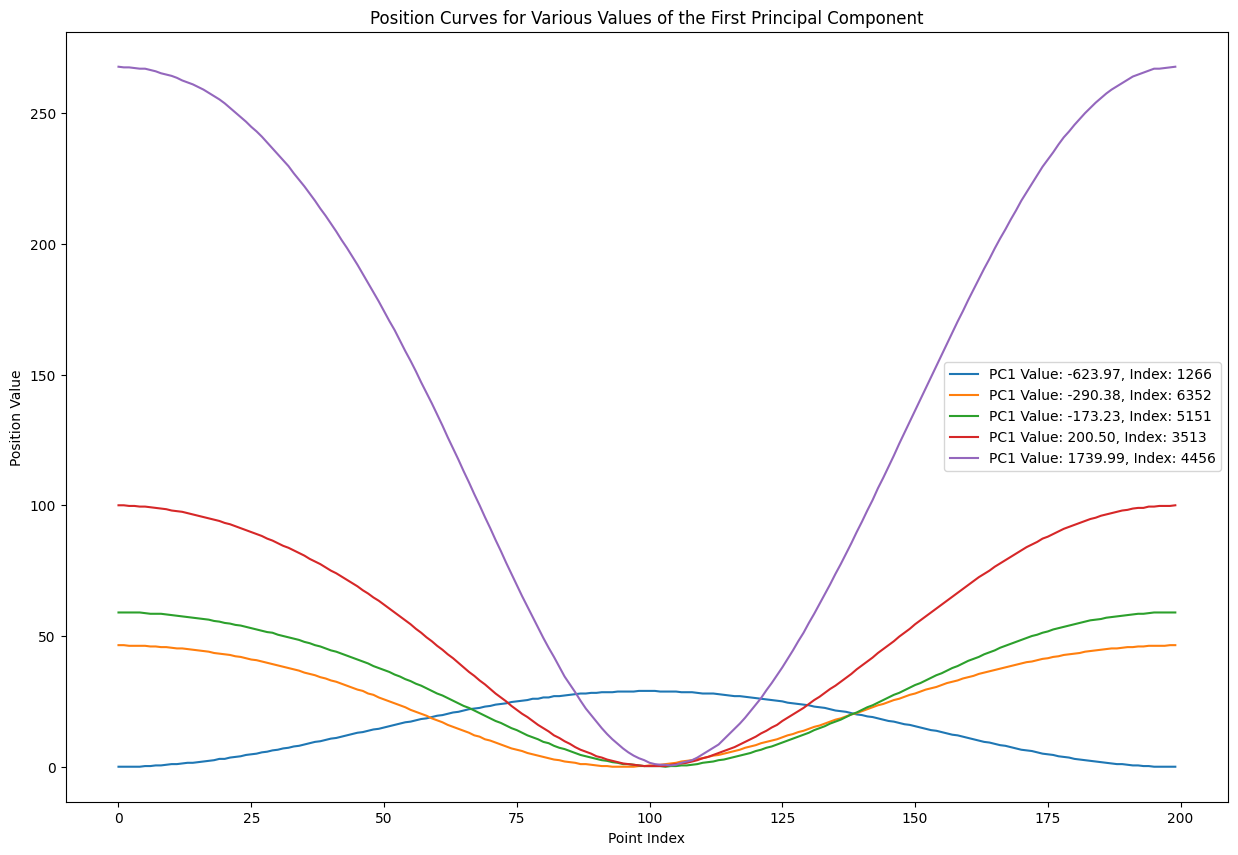

In [21]:
# Sort the PCA-transformed data by the first principal component
pca_component_1 = pos_pca.sort_values(by=0)

# Function to plot position curves for given indices
def plot_cosine_position_curves(indices, d200_data):
    plt.figure(figsize=(15, 10))
    for index in indices:
        positions = d200_data.loc[index, 'Position0':'Position199']
        plt.plot(range(200), positions, label=f'PC1 Value: {pca_component_1.loc[index, 0]:.2f}, Index: {index}')
    plt.title('Position Curves for Various Values of the First Principal Component')
    plt.xlabel('Point Index')
    plt.ylabel('Position Value')
    plt.legend()
    plt.show()

# Sample indices from the sorted PCA DataFrame to cover a range from small to large values of the first principal component
indices_to_sample = [
    pca_component_1.index[0],  # Minimum value of PC1
    pca_component_1.index[len(pca_component_1) // 4],  # 25th percentile
    pca_component_1.index[len(pca_component_1) // 2],  # Median
    pca_component_1.index[3 * len(pca_component_1) // 4],  # 75th percentile
    pca_component_1.index[-1]  # Maximum value of PC1
]

# Plot the position curves for the sampled indices
plot_cosine_position_curves(indices_to_sample, d200_clean)

Observing the graph, we can see that:

The curve associated with the lowest PC1 value (deep purple) has the highest peak and the most pronounced vertical displacement. This suggests that as the PC1 value decreases, the amplitude of the position curve increases, which could indicate a full and strong pumping action.

Curves with higher PC1 values (green, orange, red, blue) tend to have lower vertical displacements. This may suggest that these pumps are not lifting as much fluid or are experiencing less resistance, resulting in a flatter curve.

The curve with the highest PC1 value (bright blue) shows the smallest vertical displacement, indicating the least amount of movement in the pump rod or possibly the presence of an issue such as a worn pump or fluid pound.

The trend visible in the graph implies that the first principal component is capturing the variance related to the amplitude or the "cosine-like" feature of the position curves. Therefore, PC1 could be considered a measure of the pump stroke's effectiveness or an indicator of certain mechanical conditions within the wells. Pumps with a higher stroke amplitude (lower PC1 values) might be working more vigorously or efficiently than those with a lower amplitude (higher PC1 values). However, extremely high amplitudes could also indicate potential issues, such as equipment overexertion or other mechanical stressors.

### TODO: Plot Scatter Matrix
Plot the 5x5 scatter matrix using the first five dimensions of the pos_pca points

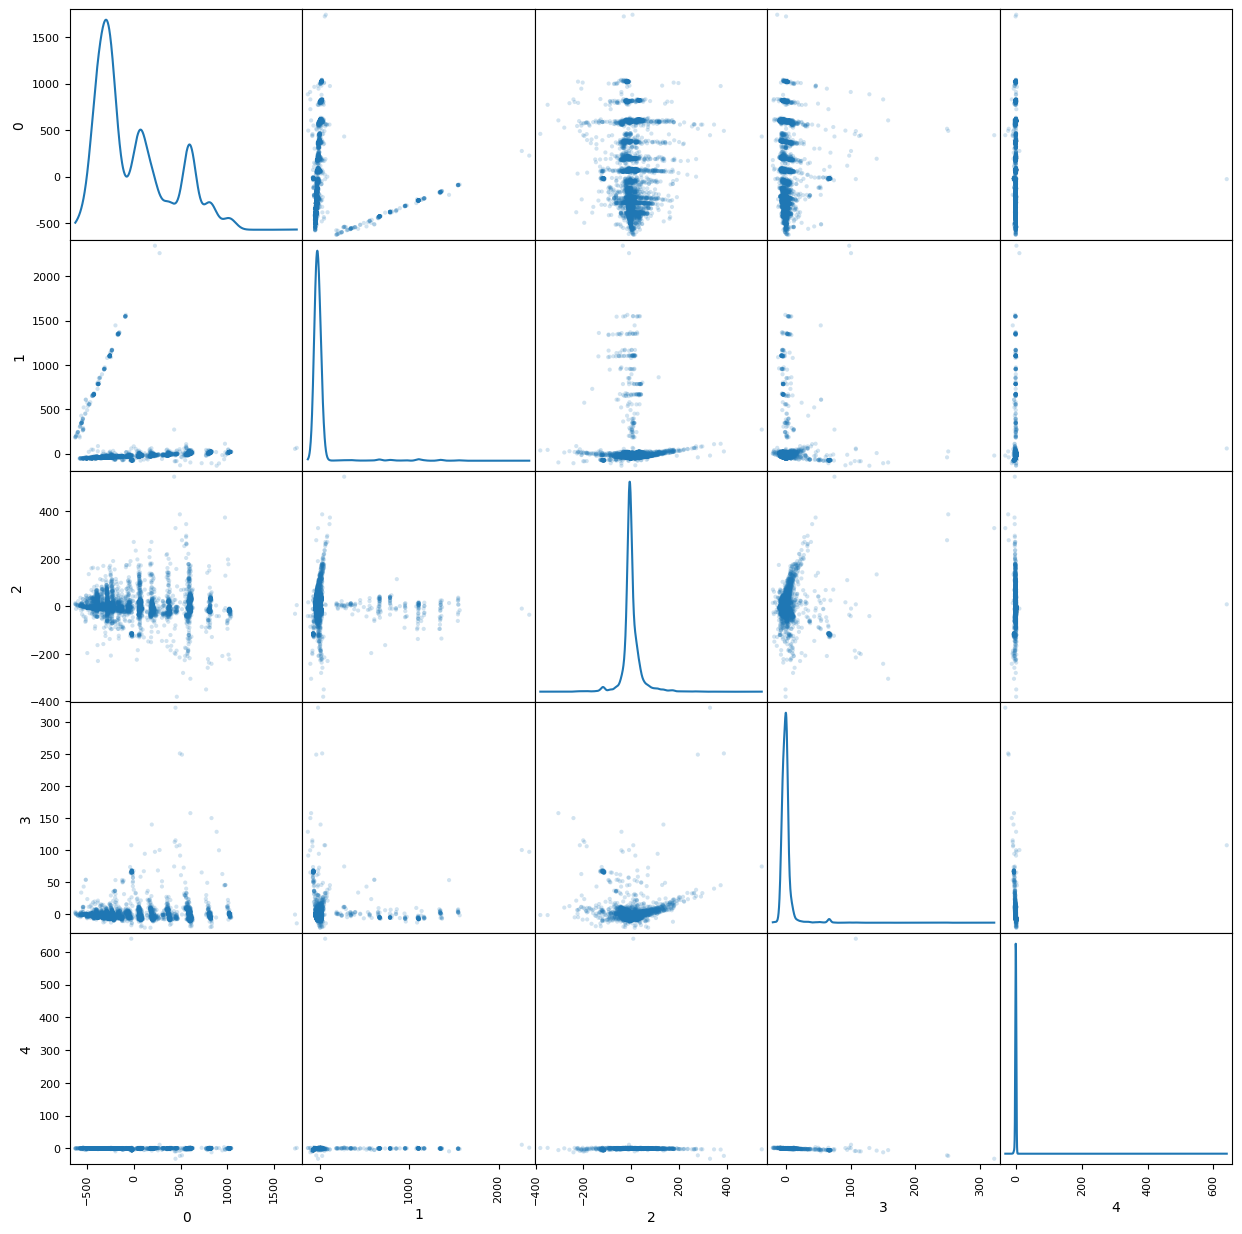

In [22]:
from pandas.plotting import scatter_matrix
scatter_matrix(pos_pca.iloc[:, :5], alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

### TODO: What does principal component three, i.e. pos_pca[:, 2], represent?

Let's focus on just the "cosine" position curves.  Generate a figure with position curves with very small pos_pca[:, 2] and very large pos_pca[:, 2] values.

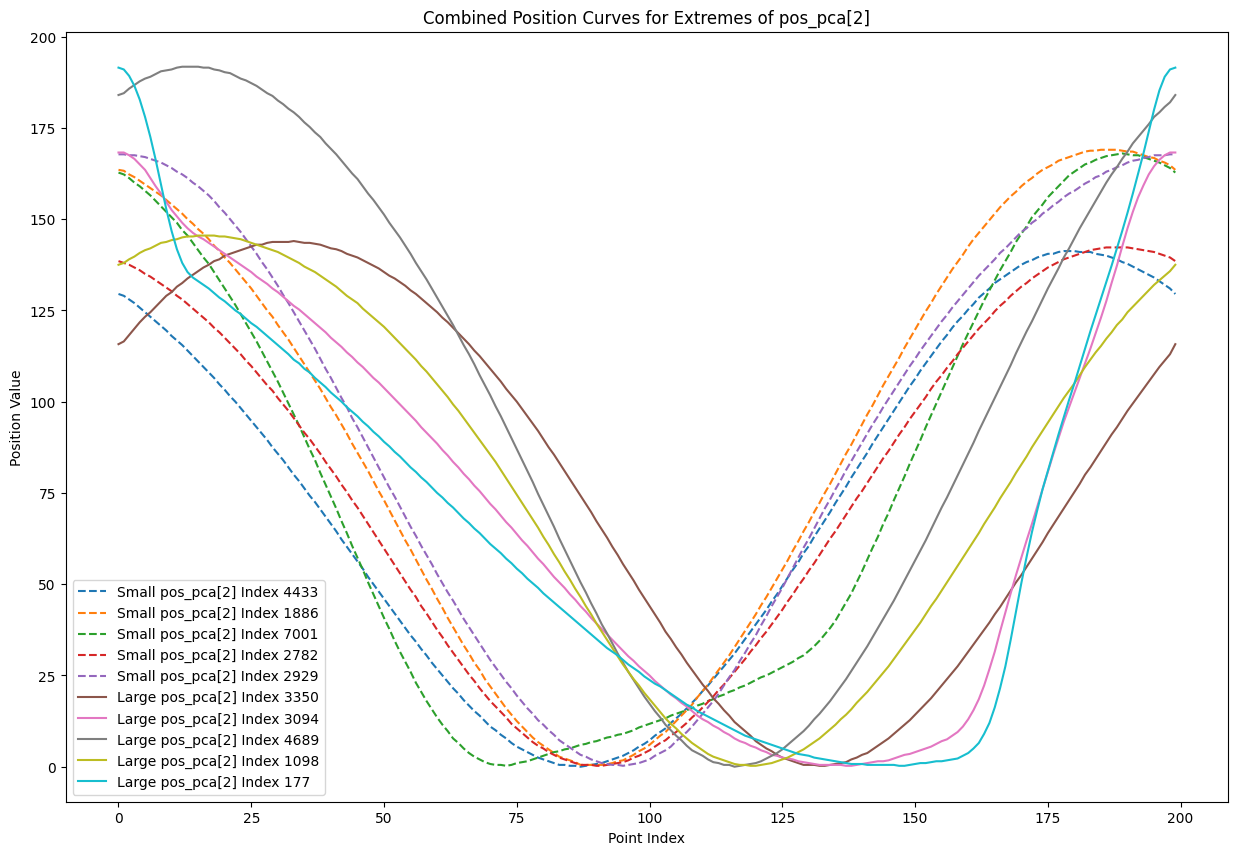

In [23]:
third_component = pos_pca[2]
smallest_indices = third_component.nsmallest(5).index
largest_indices = third_component.nlargest(5).index

# Function to plot position curves for selected indices on the same graph
def plot_combined_position_curves(small_indices, large_indices, title, d200_clean):
    plt.figure(figsize=(15, 10))
    
    # Plot position curves for cards with very small pos_pca[2] values
    for index in small_indices:
        positions = d200_clean.loc[index, 'Position0':'Position199']
        plt.plot(range(200), positions, label=f'Small pos_pca[2] Index {index}', linestyle='--')
    
    # Plot position curves for cards with very large pos_pca[2] values
    for index in large_indices:
        positions = d200_clean.loc[index, 'Position0':'Position199']
        plt.plot(range(200), positions, label=f'Large pos_pca[2] Index {index}', linestyle='-')
    
    plt.title(title)
    plt.xlabel('Point Index')
    plt.ylabel('Position Value')
    plt.legend()
    plt.show()

# Plot position curves for cards with very small and very large pos_pca[2] values on the same graph
plot_combined_position_curves(smallest_indices, largest_indices, 'Combined Position Curves for Extremes of pos_pca[2]', d200_clean)



Here are some observations based on the graph:

Variation in Curves: The curves with small and large values of PC3 show significant variability. The cards represented by dashed lines have small PC3 values, and the solid lines represent cards with large PC3 values. This variation indicates that PC3 captures a distinctive aspect of the stroke motion.

Impact of PC3: The curves with small PC3 values appear to have a different shape or pattern compared to those with large PC3 values. This suggests that PC3 may be capturing some variation in the rod pump behavior that is consistent within these two groups but different between them.

Potential Mechanical Significance: The differences highlighted by PC3 could be related to specific mechanical dynamics of the pump system, such as pump fillage, fluid pound, gas interference, or other conditions affecting the pump's motion.

Stroke Patterns: Some of the curves with large PC3 values show sharper changes in the position, which could indicate a more erratic or less smooth pumping action, potentially pointing to mechanical issues that may not be present or as pronounced in the pumps represented by the curves with small PC3 values.

# Clustering

## KMeans

### TODO: Generate KMeans clustering

Use KMeans clustering to cluster the pos_pca DataFrame. Select a large number for k, say k=40.

In [24]:
# KMeans clustering
kmeans = KMeans(n_clusters=40, random_state=0)
clusters = kmeans.fit_predict(pos_pca)

# Adding the cluster labels to the pos_pca DataFrame
pos_pca['Cluster'] = clusters

### TODO: Plot the position profile of each of the cluster centers.

Use the PCA.inverser_transform() method to map the pca coordinate points back to the positions.

Note: inverser_transform() is just a convenience for:  pos_pca @ pca_clean.components_ + pca_clean.mean_



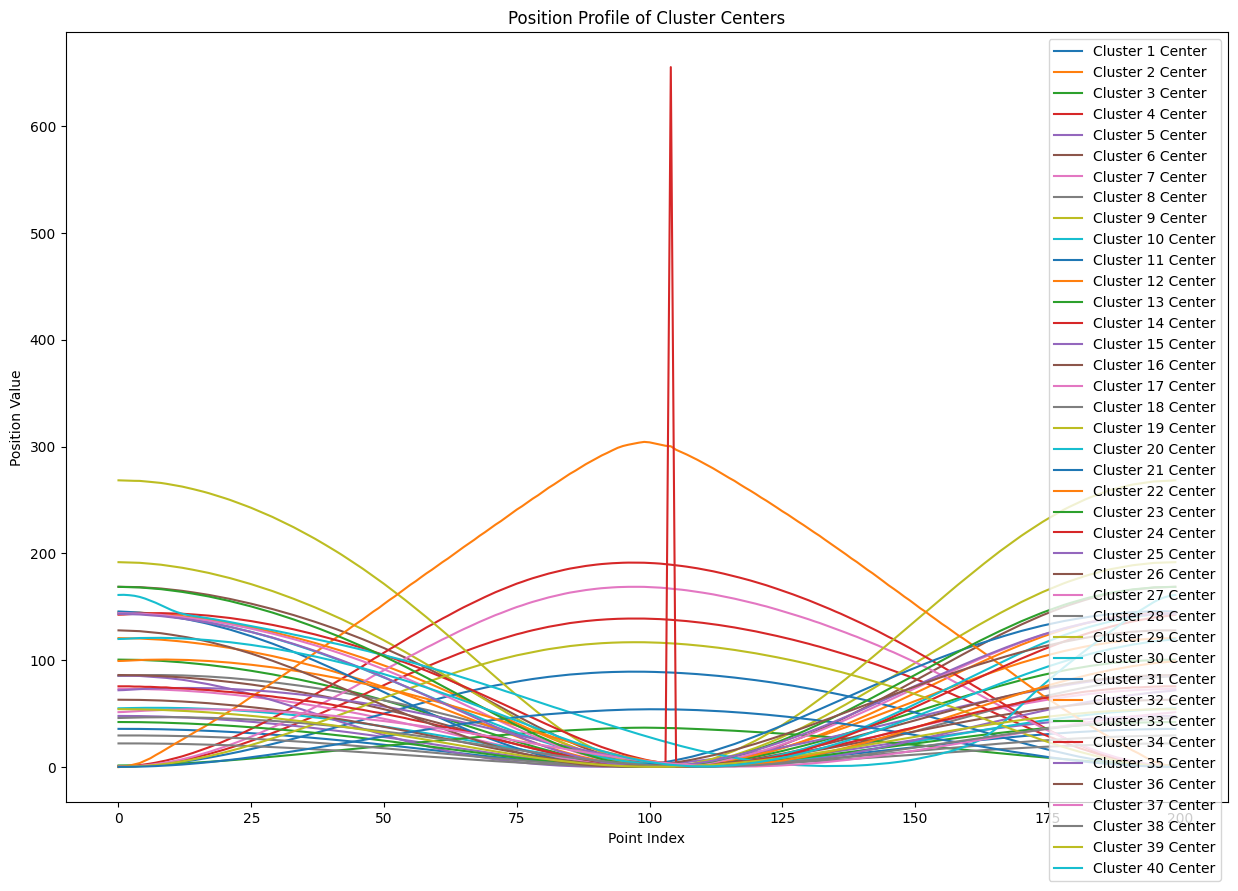

In [25]:
# Plotting the position profile of each of the cluster centers
cluster_centers = pca_clean.inverse_transform(kmeans.cluster_centers_)
# cluster_centers = kmeans.cluster_centers_
# cluster_centers_positions = cluster_centers @ pca_clean.components_ + pca_clean.mean_

plt.figure(figsize=(15, 10))
for i, center in enumerate(cluster_centers):
    plt.plot(range(200), center, label=f'Cluster {i+1} Center')
plt.title('Position Profile of Cluster Centers')
plt.xlabel('Point Index')
plt.ylabel('Position Value')
plt.legend()
plt.show()

### TODO: Plot Scatter Matrix

Plot scatter matrix of just the cluster centers using PCA components as axis.

Compare this scatter matrix of cluster centers with the the scatter matrix of all points to check if kMeans centers are representative of all the points

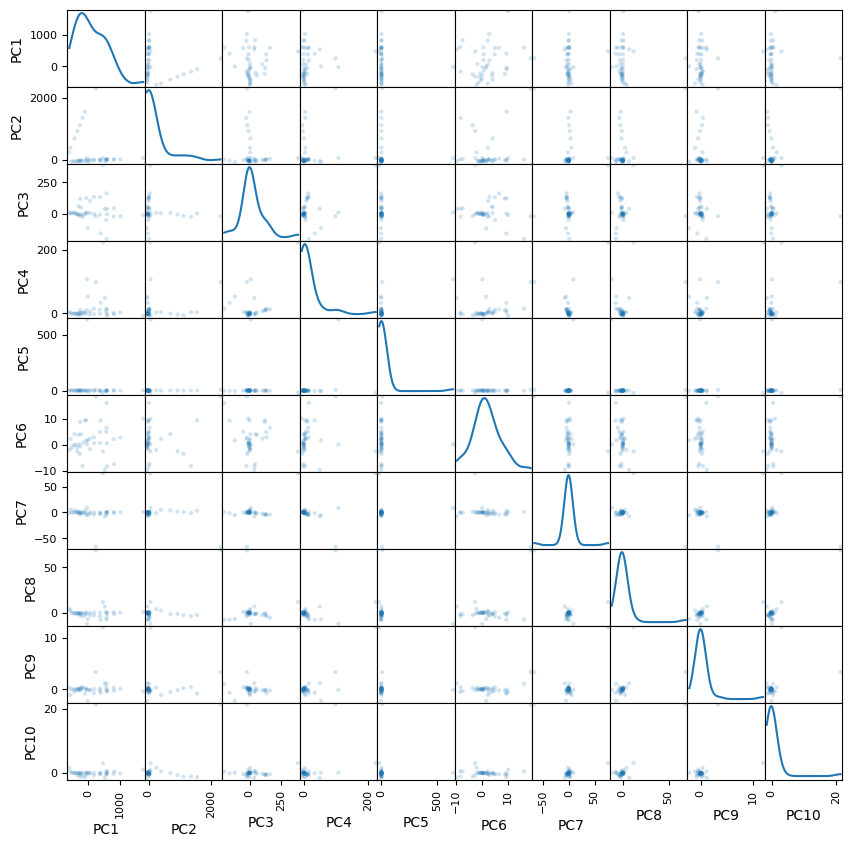

In [27]:
# Convert cluster centers (in PCA space) to DataFrame
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=[f'PC{i+1}' for i in range(kmeans.cluster_centers_.shape[1])])

# Plot scatter matrix for cluster centers
scatter_matrix(cluster_centers_df, alpha=0.2, figsize=(10, 10), diagonal='kde')
plt.show()

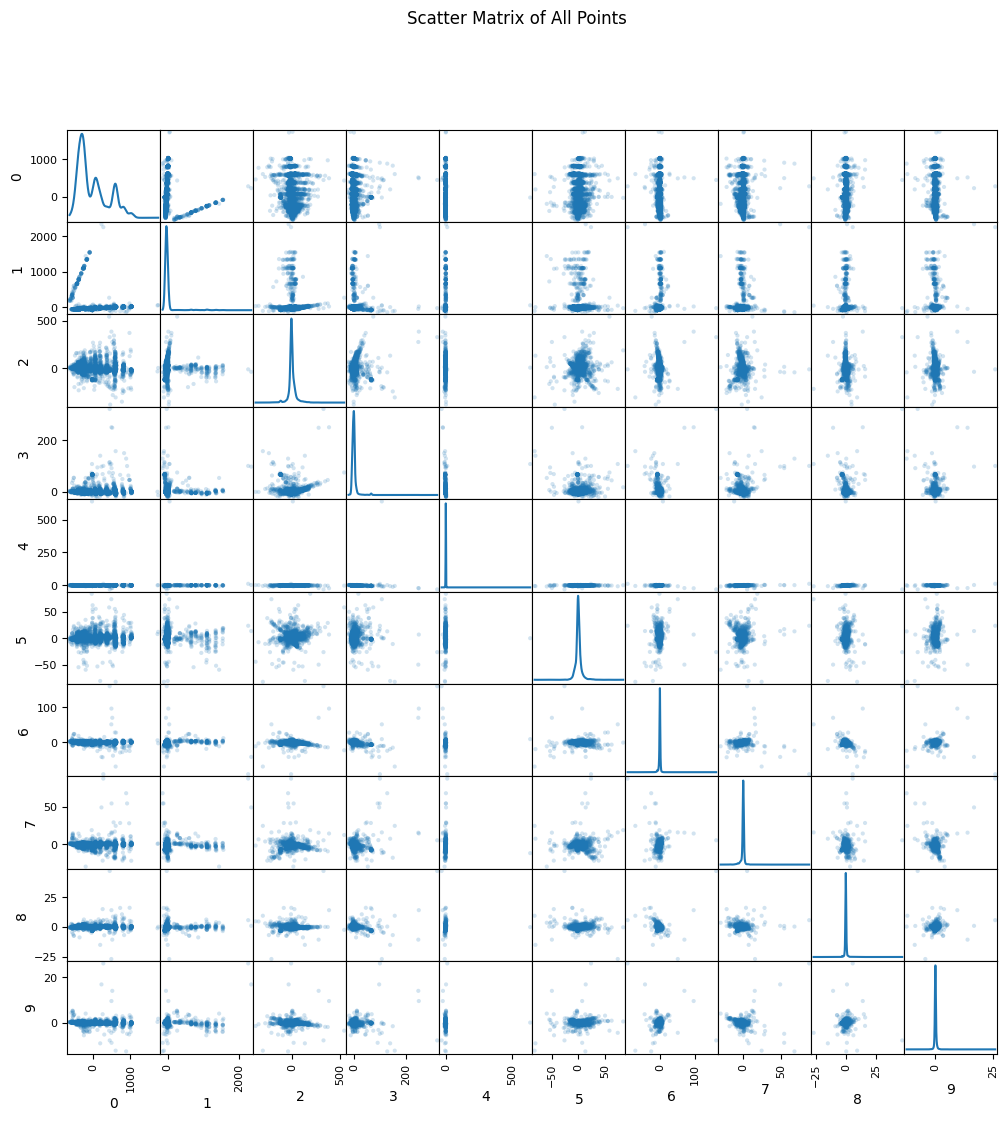

In [29]:
# Creating a DataFrame for all points PCA components excluding 'Cluster' column
pos_pca_df = pos_pca.drop(columns=['Cluster'])

# Plotting scatter matrix for all points
scatter_matrix(pos_pca_df, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.suptitle('Scatter Matrix of All Points')
plt.show()

### TODO: Generate Inset Plots

Create an inset plot with principal component 1 and principal component 2 as the axis. This plot is similar to the scatter plot, except instead of plotting points plot the position curves that correspond to the point.

See [inset_axes()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.inset_axes.html) method.

Your plot should look something like this:

![image.png](sample.png)

ValueError: too many values to unpack (expected 2)

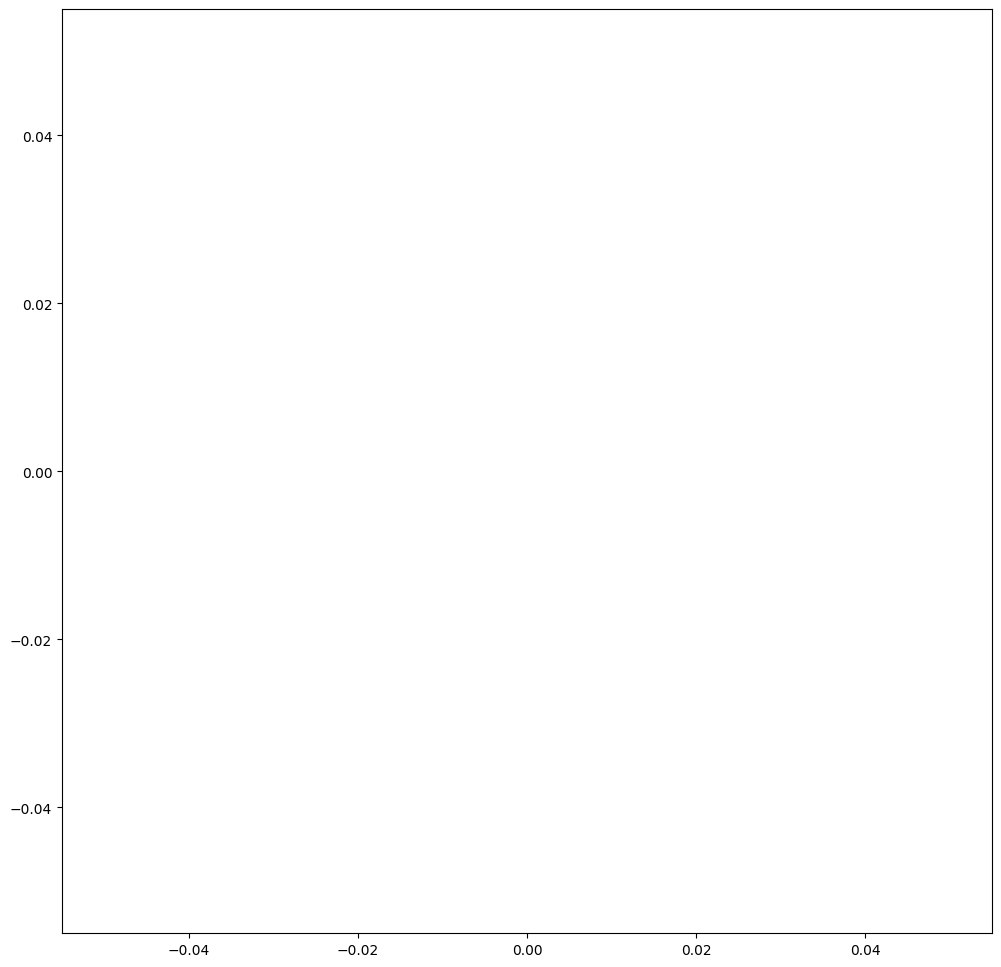

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# Define the size of the entire plot
plt.figure(figsize=(12, 12))
plt.scatter([], [])

# Define the size of the insets
inset_width = 0.05  # These can be adjusted
inset_height = 0.05  # These can be adjusted

# Get current axis of the main plot
main_ax = plt.gca()

# Randomly select 50 points
random_indices = np.random.choice(pos_pca.index, size=50, replace=False)
selected_points = pos_pca.loc[random_indices]

# Loop over the selected random points and create an inset for each one
for index, (pc1, pc2) in selected_points.iterrows():
    # Extract the positions for the inset plot
    positions = d200_clean.loc[index, 'Position0':'Position199']

    # Normalize the location for the inset axis
    inset_x = (pc1 - plt.xlim()[0]) / (plt.xlim()[1] - plt.xlim()[0])
    inset_y = (pc2 - plt.ylim()[0]) / (plt.ylim()[1] - plt.ylim()[0])

    # Create an inset axis at the normalized location
    inset_ax = inset_axes(main_ax, width=inset_width, height=inset_height,
                          bbox_to_anchor=(inset_x, inset_y),
                          bbox_transform=main_ax.transAxes, loc=3, borderpad=0)
    
    # Plot the position curve on the inset axis
    inset_ax.plot(positions, color='black')
    inset_ax.set_xlim(0, 199)  # Make sure your x-limits match the index range of your positions
    inset_ax.set_ylim(min(positions), max(positions))  # Adjust y-limits to match data range
    inset_ax.axis('off')  # Turn off the axis

# Set the main plot's labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Transformed Coordinates with Inset Position Curves for Random 50 Points')

# Display the plot
plt.show()

## Affinity Propagation

[Affinity Propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation) is clustering technique that unlike kmeans does not require the number of clusters as input.

However, affinity propagation can be slow and sometime it may not converge with the default `max_iter=200`.

Generate a clustering using affinity propagation using the position values `d200_clean.iloc[:, 5:205]` directly, instead of PCA projected values. Adjust these parameters as need to make sure affinity propagation converges.

* `max_iter`
* `damping`

### TODO: Generate Affinity Propagration Clustering

In [32]:
%%time
# Generate a clustering using Affinity Propagation
affinity_clustering = AffinityPropagation(max_iter=200, damping=0.75).fit(d200_clean.iloc[:, 5:205])
affinity_cluster_centers = affinity_clustering.cluster_centers_

CPU times: total: 1min 34s
Wall time: 4min 5s


### TODO: Generate plot of position curves of the cluster centers

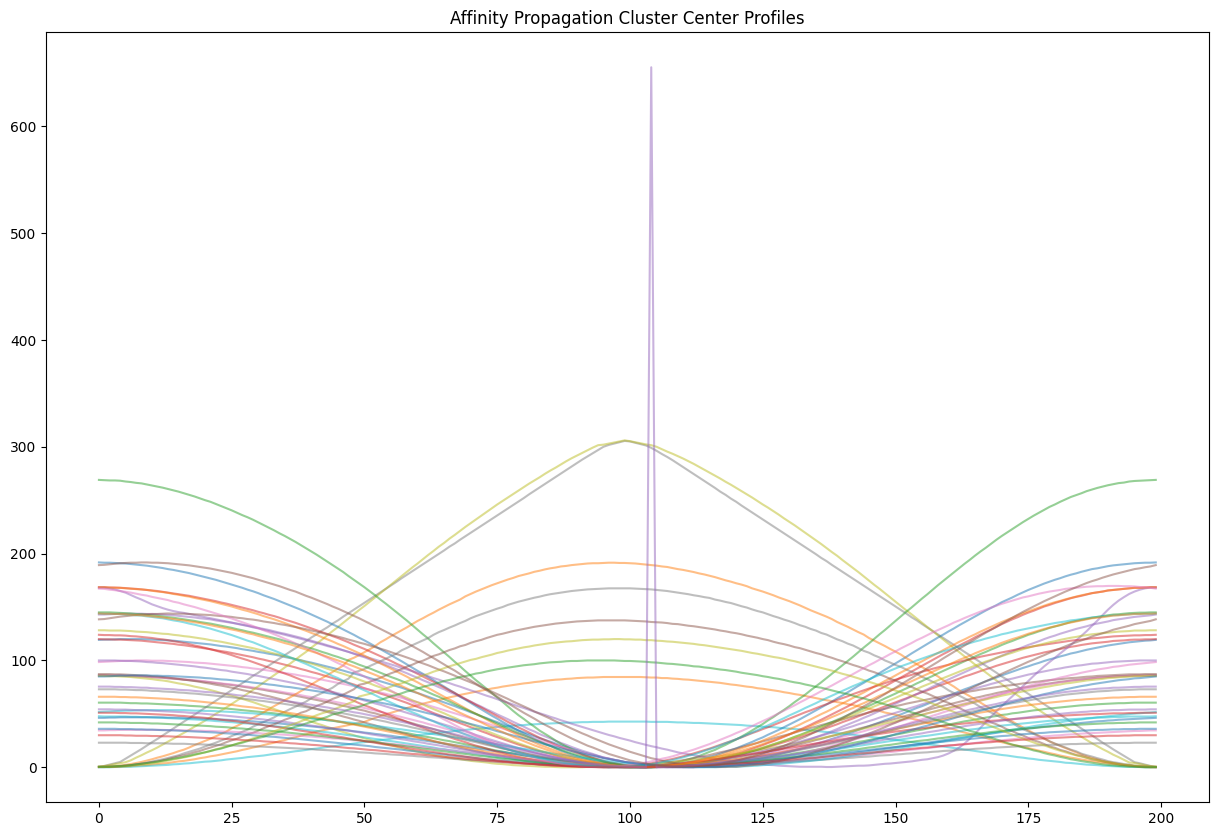

In [34]:
# Plot position curves of the cluster centers
plt.figure(figsize=(15, 10))
for center in affinity_cluster_centers:
    plt.plot(range(200), center, alpha=0.5)
plt.title('Affinity Propagation Cluster Center Profiles')
plt.show()